In [8]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [9]:
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=1000)).strftime("%Y-%m-%d")
start_date

'2021-07-19'

In [10]:
portfolio_file = "PersonalHoldings.csv"
portfolio_df = pd.read_csv(portfolio_file)
print(portfolio_df.head())

      SYMBOL  QUANTITY  AVG_COST      COST  PORTFOLIO_WEIGHT  \
0   HDFCBANK        59   1356.00  80004.00            0.1121   
1       CAMS        33   2117.50  69877.50            0.0979   
2  KOTAKBANK        37   1642.00  60754.00            0.0851   
3        TCS        16   3604.85  57677.60            0.0808   
4       INFY        28   1273.49  35657.72            0.0500   

   PORTFOLIO_WEIGHT%  
0              11.21  
1               9.79  
2               8.51  
3               8.08  
4               5.00  


In [11]:
tickers = [symbol + '.NS' for symbol in portfolio_df['SYMBOL']][0:2]
tickers

['HDFCBANK.NS', 'CAMS.NS']

In [12]:
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

print(data_pivoted.head())
stock_data = data_pivoted.reset_index()

Attribute                 Adj Close        Close         High          Low  \
Date       Ticker                                                            
2021-07-19 CAMS.NS      3293.595947  3446.500000  3530.000000  3348.050049   
           HDFCBANK.NS  1437.606934  1471.000000  1488.849976  1466.000000   
2021-07-20 CAMS.NS      3268.080811  3419.800049  3525.000000  3402.649902   
           HDFCBANK.NS  1410.389160  1443.150024  1454.000000  1436.150024   
2021-07-22 CAMS.NS      3215.138428  3364.399902  3499.000000  3350.100098   

Attribute                 Open      Volume  
Date       Ticker                           
2021-07-19 CAMS.NS      3413.0    626795.0  
           HDFCBANK.NS  1487.0  12555800.0  
2021-07-20 CAMS.NS      3475.0    250007.0  
           HDFCBANK.NS  1442.0  12087125.0  
2021-07-22 CAMS.NS      3465.0    186965.0  


In [13]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute        Ticker    Adj Close        Close         High          Low  \
Date                                                                          
2021-07-19      CAMS.NS  3293.595947  3446.500000  3530.000000  3348.050049   
2021-07-19  HDFCBANK.NS  1437.606934  1471.000000  1488.849976  1466.000000   
2021-07-20      CAMS.NS  3268.080811  3419.800049  3525.000000  3402.649902   
2021-07-20  HDFCBANK.NS  1410.389160  1443.150024  1454.000000  1436.150024   
2021-07-22      CAMS.NS  3215.138428  3364.399902  3499.000000  3350.100098   

Attribute     Open      Volume  
Date                            
2021-07-19  3413.0    626795.0  
2021-07-19  1487.0  12555800.0  
2021-07-20  3475.0    250007.0  
2021-07-20  1442.0  12087125.0  
2021-07-22  3465.0    186965.0  


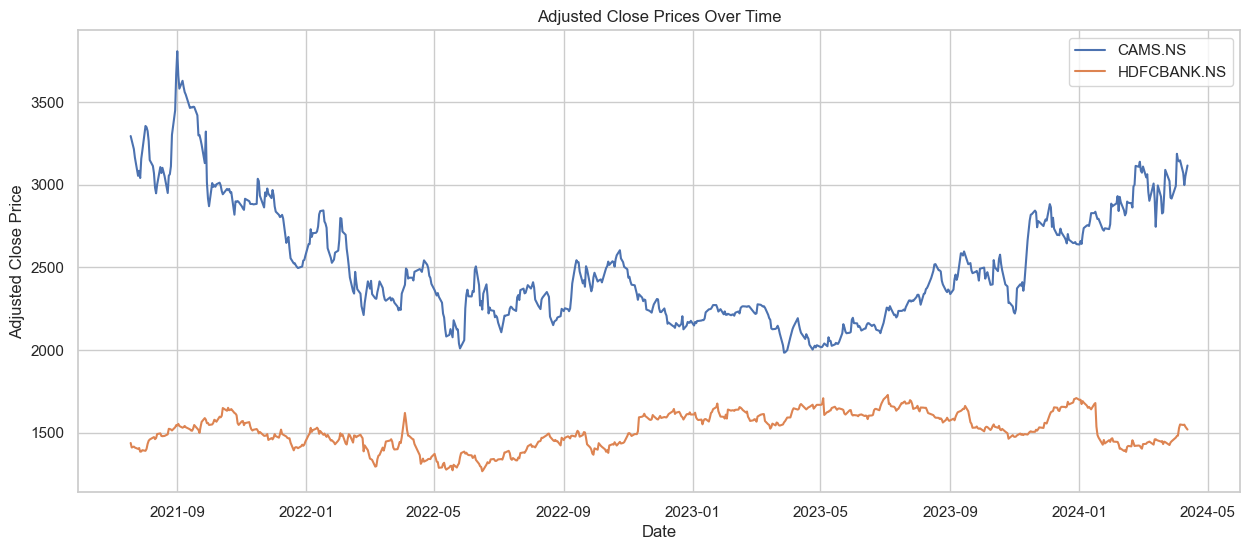

Text(0.5, 0, 'Date')

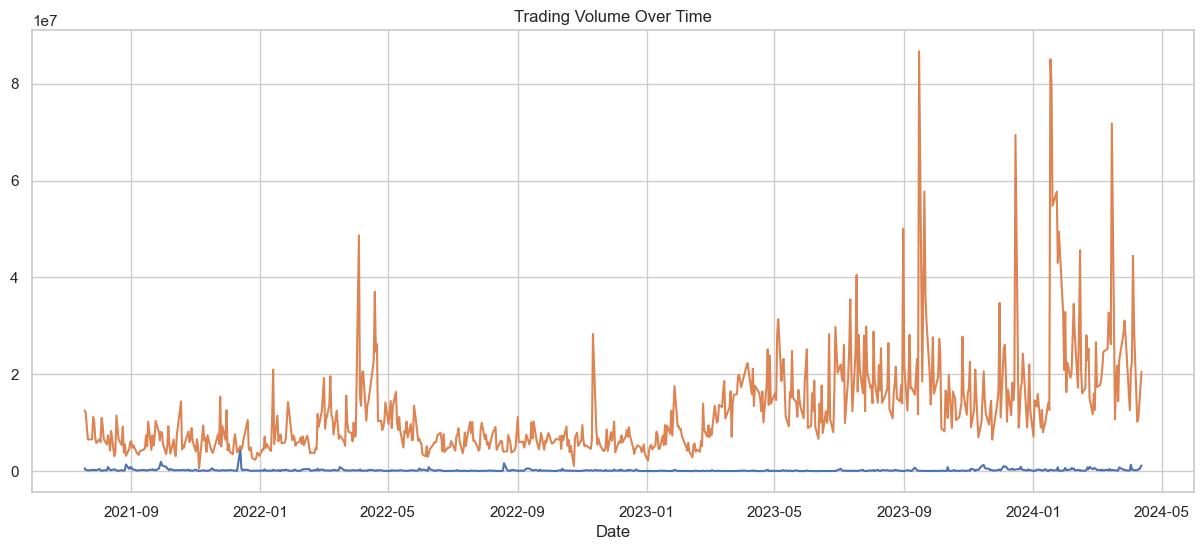

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')

In [ ]:
#For the task of stock market anomaly detection, we can use the Z-score method, 
#which identifies anomalies based on how many standard deviations away a data point is from the mean. 
#A common threshold for identifying an anomaly is a Z-score greater than 2 or less than -2, which corresponds to data points that are more than 2 standard deviations away from the mean.
#We will compute the Z-scores for both the adjusted close prices and trading volumes for each stock and then identify any data points that exceed this threshold:

In [15]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close)

Attribute        Ticker    Adj Close        Close         High          Low  \
Date                                                                          
2021-07-19      CAMS.NS  3293.595947  3446.500000  3530.000000  3348.050049   
2021-07-20      CAMS.NS  3268.080811  3419.800049  3525.000000  3402.649902   
2021-08-02      CAMS.NS  3354.500000  3497.350098  3527.699951  3350.000000   
2021-08-03      CAMS.NS  3346.922119  3489.449951  3545.000000  3465.050049   
2021-08-04      CAMS.NS  3323.662598  3465.199951  3512.050049  3441.000000   
2021-08-05      CAMS.NS  3263.763672  3402.750000  3479.449951  3390.500000   
2021-08-27      CAMS.NS  3301.360352  3435.050049  3539.899902  3289.000000   
2021-08-30      CAMS.NS  3448.454102  3588.100098  3600.000000  3485.149902   
2021-08-31      CAMS.NS  3668.205322  3816.750000  3939.899902  3515.000000   
2021-09-01      CAMS.NS  3806.312500  3960.449951  4067.399902  3888.850098   
2021-09-02      CAMS.NS  3658.402344  3806.550049  3

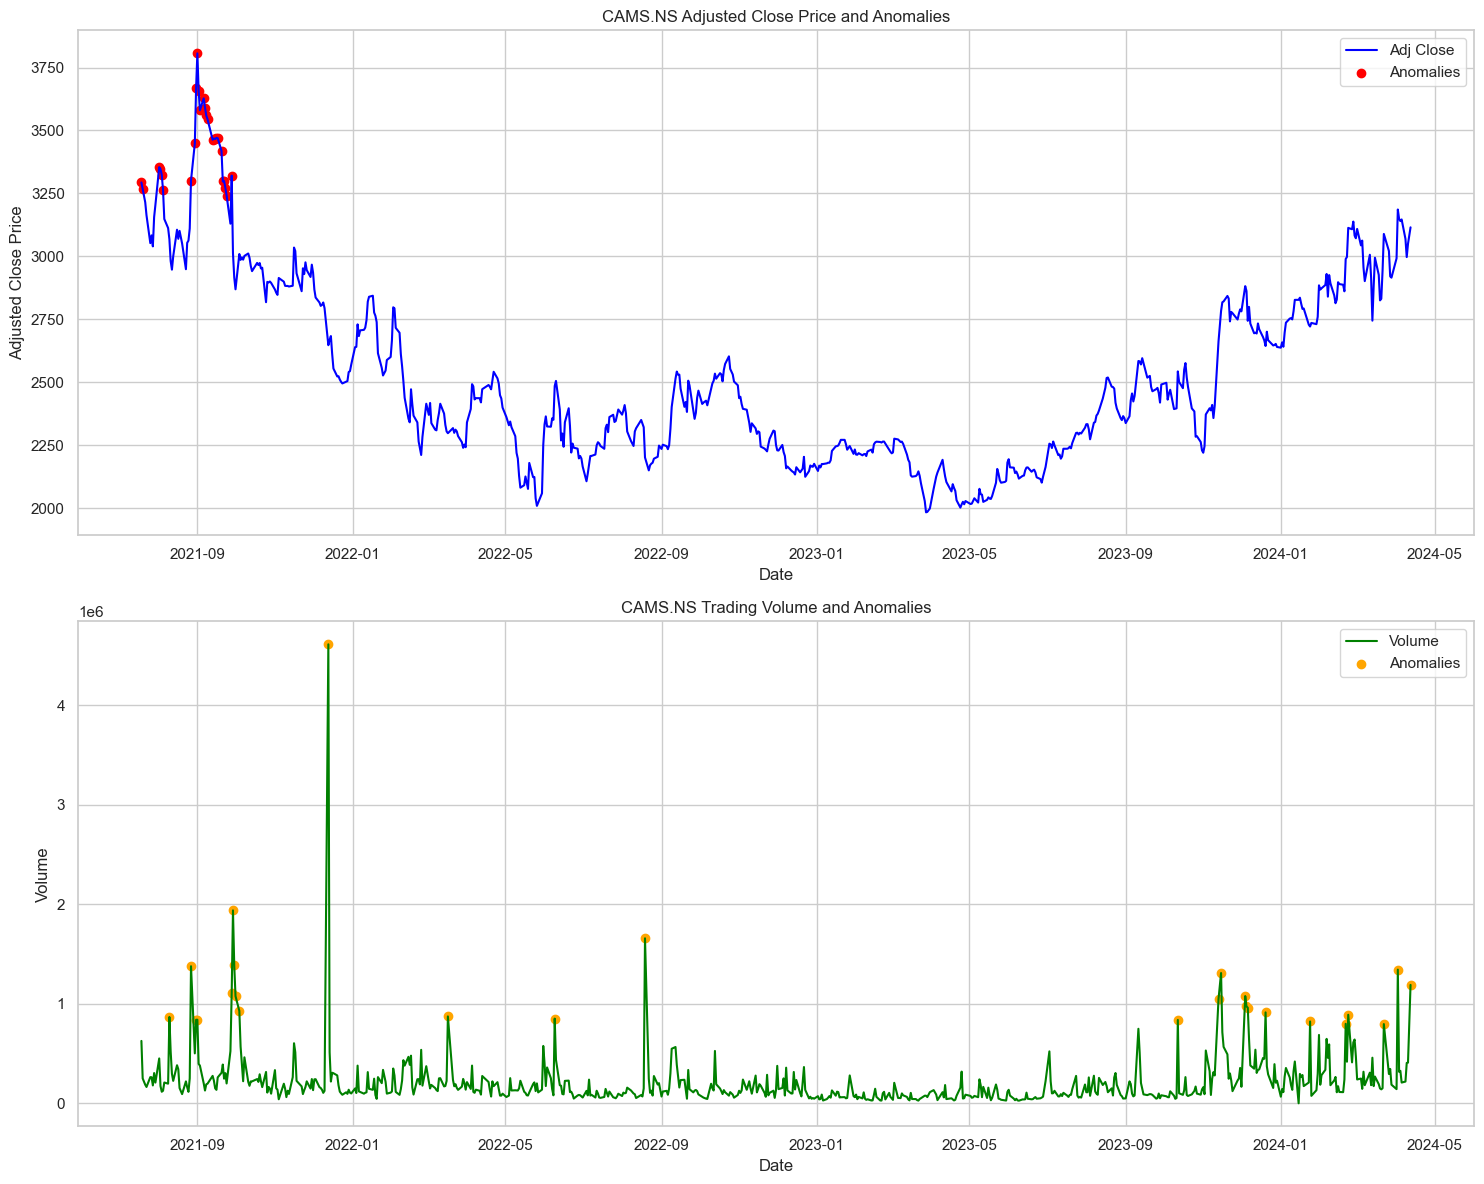

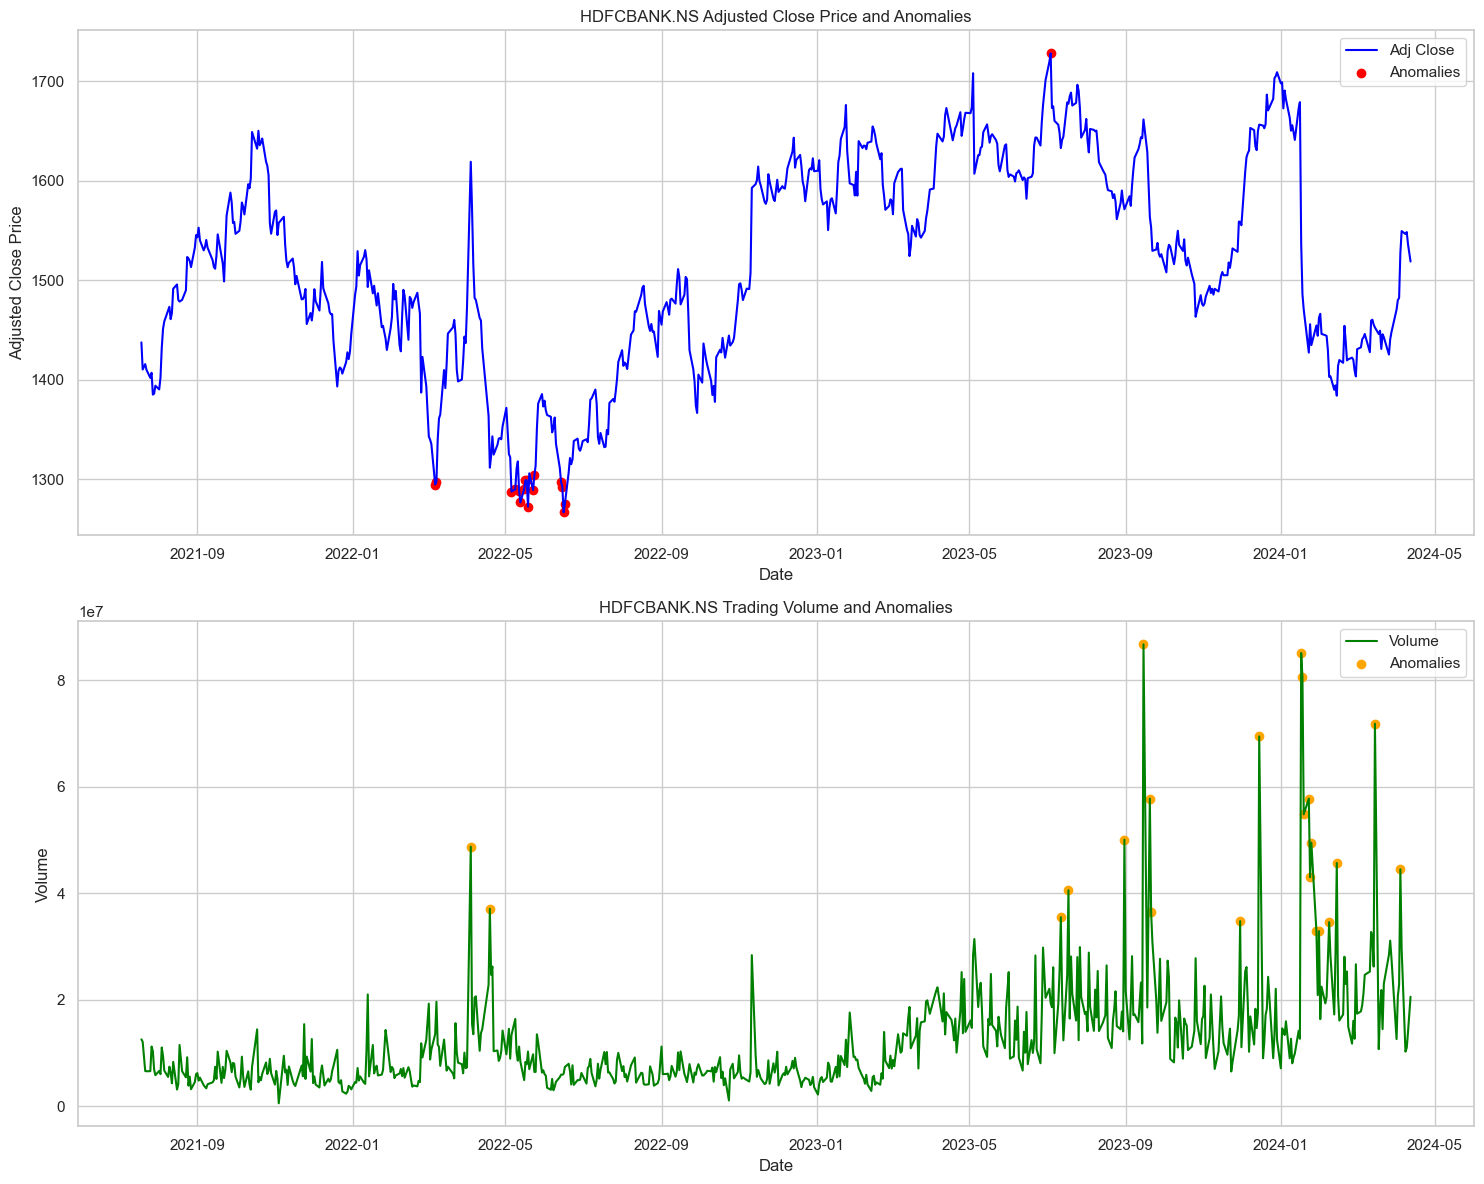

In [16]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [17]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                              Adj Close Anomaly             Volume Anomaly  \
Ticker                                  CAMS.NS HDFCBANK.NS        CAMS.NS   
                  Ticker                                                     
Adj Close Anomaly CAMS.NS                   1.0        -1.0            NaN   
                  HDFCBANK.NS              -1.0         1.0            NaN   
Volume Anomaly    CAMS.NS                   NaN         NaN       1.000000   
                  HDFCBANK.NS               NaN         NaN      -0.958036   

                                           
Ticker                        HDFCBANK.NS  
                  Ticker                   
Adj Close Anomaly CAMS.NS             NaN  
                  HDFCBANK.NS         NaN  
Volume Anomaly    CAMS.NS       -0.958036  
                  HDFCBANK.NS    1.000000  


In [18]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
CAMS.NS        1.0
HDFCBANK.NS    0.0
Name: Z-score, dtype: float64
